In [1]:
import numpy as np
import idi.simulation as sim
import idi.reconstruction as recon
import idi.util as util
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

#we will ignore some warnings
warnings.filterwarnings("ignore", r"All-NaN (slice|axis) encountered")
warnings.filterwarnings("ignore", r"Mean of empty slice", category=RuntimeWarning)
np.seterr(divide="ignore")


def print_dict(dictionary):
    from IPython.display import HTML, display
    html = "<table>"
    html +="<tr><th>Key</th><th>Value</th></tr>"
    html +="".join(f"<tr><td>{k}</td><td>{v}</td></tr>" for k,v in dictionary.items())
    html += "</table>"
    display(HTML(html))
    
print('running on ',end='')
!hostname
print()
print('free -h:',end='')
!free -h
print()
print('nvidia-smi:')
!nvidia-smi
print()

running on volt003

free -h:              total        used        free      shared  buff/cache   available
Mem:           187G         23G        154G        1.2G        9.8G        162G
Swap:          191G        300M        191G

nvidia-smi:
Tue Sep 29 16:50:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:89:00.0 Off |                    0 |
| N/A   43C    P0    61W / 300W |   1863MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
   

## Settings

In [2]:
inputfile='0-idi20-loose-multi0.npz'
Nphotons=int(1e5)
Nimg=np.inf # np.inf: use all
degrade=True

## Prepare  Data

In [3]:
f=np.load(inputfile,allow_pickle=True)
probs=f['result']
z=f['settings'][0]['detz']*0.01/f['settings'][0]['pixelsize']/1e-6
_Nimg=min(Nimg,probs.shape[0])

print('loaded settings:')
print_dict(f['settings'][0])

loaded settings:


Key,Value
Natoms,10000000
Ndet,1024
detz,30
Nimg,100
a,3.6
r,20
pixelsize,50
E,6400
rndphase,True
rotangles,[0. 0. 0.]


### Image Degradation

In [4]:
#static degradation
if degrade:
    def mesh(*args):
        ranges=[np.arange(d) for d in args]
        return np.meshgrid(*ranges)

    #mask
    mask=np.ones_like(probs[0,...])
    mask[500:-500,:]=0
    mask[:,475:-475]=0
    probs=probs*mask

    #simulate transmission through an filter
    x,y=mesh(probs.shape[1],probs.shape[2])
    c=(np.array(probs.shape)//2)[1:]
    filter=(1-(0.1*np.abs(x-c[0])/c[0]))*(1-(0.05*np.abs(y-c[1])/c[1]))**2
    filter+=np.random.randn(*filter.shape)/20
    
    #uneven detector
    stripes=np.tile((1+0.1*np.random.randn(16)[:,None]).repeat(probs.shape[1]//16),(probs.shape[2],1))

    #apply
    degrade=filter*stripes*mask
    probs=probs*degrade
    

In [5]:
# simulate random photons
images=sim.common.randomphotons(probs,Nphotons)[:_Nimg]

In [6]:
#add noise photons
noise=np.array(sim.common.randomphotons(np.ones_like(images),int(Nphotons/100))).astype(float)
noise+=np.random.rand(*images.shape)/5
images=images+noise

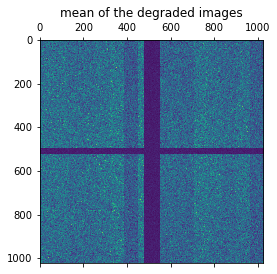

In [7]:
plt.matshow(images.mean(axis=0))
plt.title('mean of the degraded images');

## Reconstruction

### simple Autocorrelation

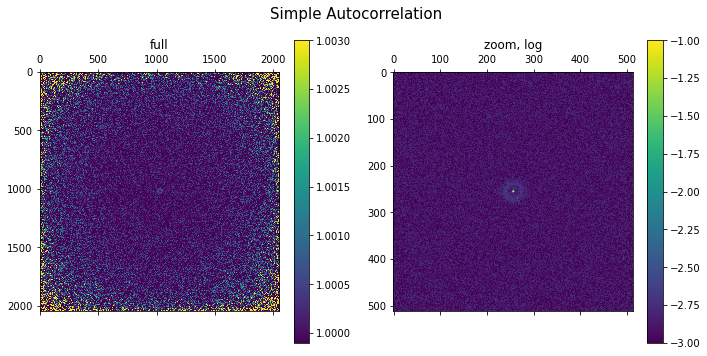

In [8]:
simple=np.mean(recon.cusimple.corr(images,norm=True),axis=0)
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

im1=ax1.matshow(simple,vmin=0.9999,vmax=1.003)
ax1.set_title('full')
plt.colorbar(im1,ax=ax1)

zoom=simple[3*simple.shape[0]//8:-3*simple.shape[0]//8,3*simple.shape[1]//8:-3*simple.shape[1]//8]
im2=ax2.matshow(np.log10(zoom-np.min(zoom)),vmax=-1,vmin=-3)
ax2.set_title('zoom, log')
plt.colorbar(im2,ax=ax2)
f.suptitle('Simple Autocorrelation',fontsize=15)
f.tight_layout()

### q corrected radial profile

Text(0.5, 1.0, 'q corrected radial profile')

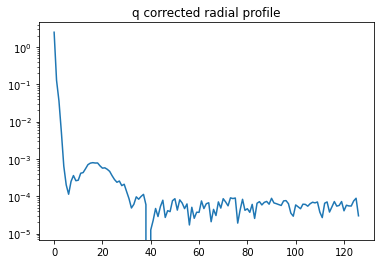

In [9]:
qmax=127
mean=np.mean(images,axis=0)

with recon.cucorrad.corrfunction(mean.shape,z,qmax) as f:
    result=sum(f(image/mean) for image in tqdm(images))
    norm=1/(f(np.ones_like(mean))*len(images))
    result*=norm
    
plt.semilogy(result-np.min(result))
plt.title('q corrected radial profile')

### q corrected autocorrelation

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


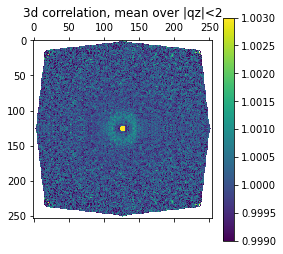

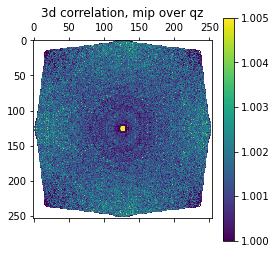

In [10]:
qmax=127
minpairs=5e4
mean=np.mean(images,axis=0)*np.sqrt(len(images))
from tqdm.notebook import tqdm
with recon.cucor.corrfunction(mean.shape,z,qmax) as f:
    result=sum(f(image/mean).astype(np.float64) for image in tqdm(images))
    norm=f(np.ones_like(mean)).astype(np.float64)
    result/=norm
    result[norm<minpairs]=np.nan

plt.matshow(np.nanmean(result[result.shape[0]//2-2:result.shape[0]//2+2,...],axis=0),vmax=1.003,vmin=0.999)
plt.title('3d correlation, mean over |qz|<2')
plt.colorbar()
plt.show()

plt.matshow(np.nanmax(result,axis=0),vmax=1.005,vmin=1)
plt.title('3d correlation, mip over qz')
plt.colorbar()
plt.show()

### 3d (q corrected) FFT Autocorrelation

In [11]:
mean=np.mean(images[:_Nimg],axis=0)
res=recon.ft.corr(images[:_Nimg,...]/mean,z,verbose=True)
norm=recon.ft.corr(np.ones_like(mean),z,verbose=True)
res[norm<1e4]=np.nan
res=recon.ft.unwrap(res*(1/(len(images)*norm)))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 . 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  after removing the cwd from sys.path.


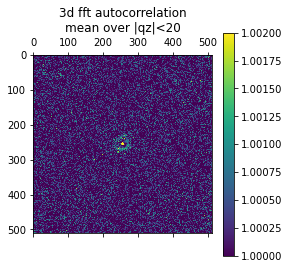

In [12]:
zoom=res[:20,3*res.shape[1]//8:-3*res.shape[1]//8,3*res.shape[2]//8:-3*res.shape[2]//8]
plt.matshow(np.nanmean(zoom,axis=0),vmin=1,vmax=1.002)
plt.title('3d fft autocorrelation\nmean over |qz|<20')
plt.tight_layout()
plt.colorbar()